In [1]:
from typing import Callable, Tuple
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision.transforms import v2

from model.vae import Encoder, Decoder, AutoEncoder
from model.train import train

from utils.dataset import dataset
from utils.devices import getDevice

device = getDevice()

In [2]:
def KL_loss(mean:torch.Tensor, logVar:torch.Tensor) -> torch.Tensor:
    kl_loss = -(0.5) * torch.sum( 1 + logVar - mean**2 - torch.exp(logVar) )
    return kl_loss

def loss(x:torch.Tensor, x_hat:torch.Tensor, mean:torch.Tensor, logVar:torch.Tensor) -> Tuple[torch.Tensor]:
    reproLoss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kl_loss = KL_loss(mean, logVar)

    return reproLoss, kl_loss, reproLoss + kl_loss

In [3]:
from torch.utils.data import DataLoader
from torch import optim
from torch.optim import lr_scheduler

from torch.utils.tensorboard import SummaryWriter

def plot(t:torch.Tensor, model:nn.Module):
    t_hat, _, _ = model(t.flatten(start_dim=1))
    t_hat = t_hat.reshape((1,28,28))

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(t.squeeze())
    ax[1].imshow(t_hat.squeeze().detach().numpy())

KL(p, q) = log (sigma2 / sigma1) + [ sigma1^2 + (mu1 - mu2)^2 ] / ( 2*sigma2^2) - (1/2) 
KL(p, q) = log(sigma2) - log(sigma1) + (1/2)*(sigma1^2 / sigma2^2) + ( mu1 - mu2 )^2 / (2*sigma2^2) - 1/2

since sigma1 = 1, and mu1 = 0

KL(p,q) = log(sigma2) + (1/2) / (sigma2^2) + (mu2^2) / (2 sigma2^2) - (1/2)


https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes/370048#370048

In [4]:
import torch.utils
import torch.utils.data


data = dataset(transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]))
dl = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

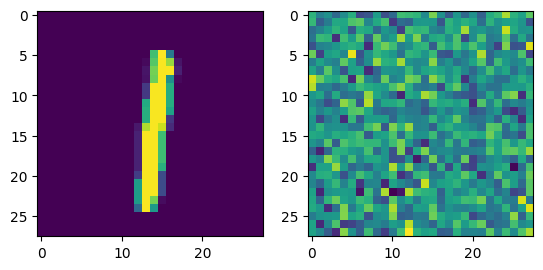

In [5]:
input_dim = 784
hidden_dim = 400
latent_dim = 200

enc = Encoder(input_dim, hidden_dim, latent_dim)
dec = Decoder(latent_dim, hidden_dim, input_dim)
vae = AutoEncoder(enc, dec)

t, _ = data[40]
plot(t, vae)

Epoch:   49 - Loss: 96.164508


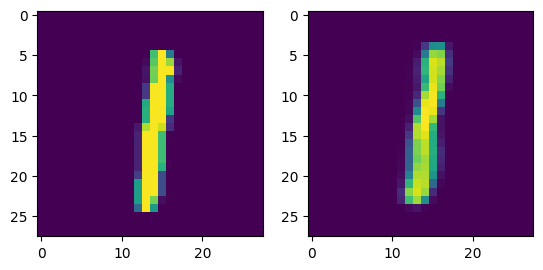

In [6]:
train(vae, dl, loss, 50)
t, _ = data[40]
plot(t, vae)

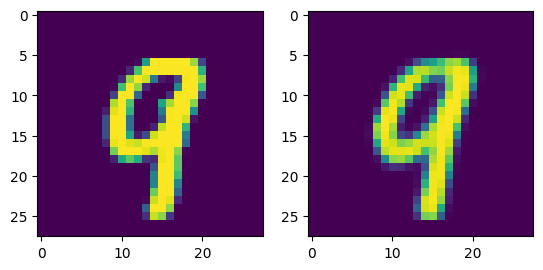

In [7]:
t, _ = data[800]
plot(t, vae)